In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths

import os

import torch
import torch.utils.data
from opts import opts
from models.model import create_model, load_model, save_model
from models.data_parallel import DataParallel
from logger import Logger
from datasets.dataset_factory import get_dataset
from trains.train_factory import train_factory
import cv2
import sys
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
sys.argv = ['-f', 'fewdetv3', '--exp_id', 'coco_dlav7','--num_workers', '0','--batch_size','2', '--arch','dlav7_34'] #cmd = 'ctdet --exp_id coco_dla --batch_size 4 --lr 1.25e-4  --gpus 0 --num_workers 0'
opt = opts().parse()
print(opt.task)
print(opt.num_workers)
print(opt.batch_size)

Fix size testing.
training chunk_sizes: [2]
The output will be saved to  C:\Users\avata\FewShot-CenterNet\src\lib\..\..\exp\fewdetv3\coco_dlav7
fewdetv3
0
2


In [3]:
torch.manual_seed(opt.seed)
torch.backends.cudnn.benchmark = not opt.not_cuda_benchmark and not opt.test

In [4]:
Dataset = get_dataset(opt.dataset, opt.task)
opt = opts().update_dataset_info_and_set_heads(opt, Dataset)
logger = Logger(opt)
os.environ['CUDA_VISIBLE_DEVICES'] = opt.gpus_str
opt.device = torch.device('cuda' if opt.gpus[0] >= 0 else 'cpu')

heads {'ss': 80, 'hm': 1, 'wh': 2, 'reg': 2}


In [5]:
model = create_model(opt.arch, opt.heads, opt.head_conv)
optimizer = torch.optim.Adam(model.parameters(), opt.lr)
start_epoch = 0
if opt.load_model != '':
    model, optimizer, start_epoch = load_model(model, opt.load_model, optimizer, opt.resume, opt.lr, opt.lr_step)

In [6]:
Trainer = train_factory[opt.task]
trainer = Trainer(opt, model, optimizer)
trainer.set_device(opt.gpus, opt.chunk_sizes, opt.device)

In [7]:
train_loader = torch.utils.data.DataLoader(
      Dataset(opt, 'train'), 
      batch_size=opt.batch_size, 
      shuffle=True,
      num_workers=opt.num_workers,
      pin_memory=True,
      drop_last=True
  )

==> initializing coco 2017 train data.
loading annotations into memory...
Done (t=13.67s)
creating index...
index created!
Loaded train 118287 samples


In [18]:
img = next(iter(train_loader))

In [19]:
print(img.keys())
print(img['input'].size())

dict_keys(['input', 'ss', 'hm', 'reg_mask', 'ind', 'wh', 'hm_og', 'reg'])
torch.Size([2, 3, 512, 512])


In [20]:
model.to('cuda')
torch.cuda.empty_cache()
outputs = model(img['input'].to('cuda'))
output = outputs[0]
print(output.keys())

dict_keys(['fc_ss', 'ss', 'hm', 'wh', 'reg'])


In [21]:
batch=img
mask = batch['reg_mask']
ind = batch['ind']
target_wh = batch['wh']
target_reg = batch['reg']

In [50]:
pos_inds = gt_hm.eq(1)
neg_inds = gt_hm.lt(1)
print(pos_inds.float().sum())
print(neg_inds.float().sum())

tensor(13.)
tensor(32755.)


In [52]:
neg_weights = torch.pow(1 - gt_hm[neg_inds], 4).to('cuda')
print(neg_weights.size())

loss = 0
pos_pred = pred_hm[pos_inds].to('cuda')
print(pos_pred)
neg_pred = pred_hm[neg_inds].to('cuda')

pos_loss = torch.log(pos_pred) * torch.pow(1 - pos_pred, 2)
neg_loss = torch.log(1 - neg_pred) * torch.pow(neg_pred, 2) * neg_weights

num_pos  = pos_inds.float().sum()
print(num_pos)
pos_loss = pos_loss.sum()
neg_loss = neg_loss.sum()
print(pos_loss)
print(neg_loss)
if pos_pred.nelement() == 0:
    loss = loss - neg_loss
else:
    loss = loss - (pos_loss + neg_loss) / num_pos
print(loss)

torch.Size([32755])
tensor([0.1063, 0.1334, 0.0963, 0.0920, 0.1166, 0.1167, 0.1094, 0.1525, 0.1173,
        0.1062, 0.1002, 0.0906, 0.1091], device='cuda:0',
       grad_fn=<IndexBackward>)
tensor(13.)
tensor(-22.7080, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-45.4723, device='cuda:0', grad_fn=<SumBackward0>)
tensor(5.2446, device='cuda:0', grad_fn=<RsubBackward1>)


In [42]:
neg_weights = torch.pow(1 - gt_hm[neg_inds], 4).to('cuda')
print(neg_weights.size())

loss = 0
pos_pred = gt_hm[pos_inds].to('cuda')
neg_pred = gt_hm[neg_inds].to('cuda')
print(neg_pred.size())

pos_loss = torch.log(pos_pred) * torch.pow(1 - pos_pred, 2)
neg_loss = torch.log(1 - neg_pred) * torch.pow(neg_pred, 2) * neg_weights
print(neg_loss.size())

num_pos  = pos_inds.float().sum()
print(num_pos)
pos_loss = pos_loss.sum()
neg_loss = neg_loss.sum()
print(pos_loss)
print(neg_loss)
if pos_pred.nelement() == 0:
    loss = loss - neg_loss
else:
    loss = loss - (pos_loss + neg_loss) / num_pos
print(loss)

torch.Size([32755])
torch.Size([32755])
torch.Size([32755])
tensor(13.)
tensor(0., device='cuda:0')
tensor(-8.9276, device='cuda:0')
tensor(0.6867, device='cuda:0')


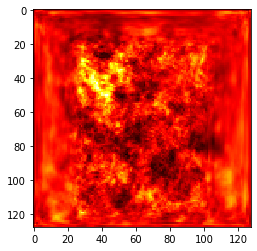

In [43]:
img_pred = pred_hm.detach().cpu().numpy()
plt.imshow(img_pred[1], cmap='hot', interpolation='nearest')

One heatmap


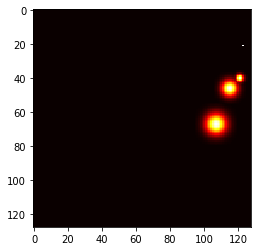

In [44]:
print('One heatmap')
img_gt = gt_hm.detach().cpu().numpy()
plt.imshow(img_gt[0], cmap='hot', interpolation='nearest')

C heatmaps summed
torch.Size([2, 80, 128, 128])


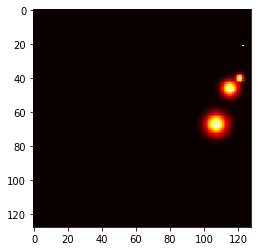

In [45]:
print('C heatmaps summed')
gt_hm2 = batch['hm_og']
print(gt_hm2.size())
img_gt2 = gt_hm2.detach().cpu().numpy() #2x80x180x180
img_gt2 = img_gt2.sum(1)/img_gt.max()
plt.imshow(img_gt2[0], cmap='hot', interpolation='nearest')

In [46]:
#Predicted vs hm_og sum dim 1
gt_hm2 = gt_hm2.sum(1)/img_gt.max()
neg_weights = torch.pow(1 - gt_hm2[neg_inds], 4).to('cuda')
print(neg_weights.size())

loss = 0
pos_pred = pred_hm[pos_inds].to('cuda')
neg_pred = pred_hm[neg_inds].to('cuda')
print(neg_pred.size())

pos_loss = torch.log(pos_pred) * torch.pow(1 - pos_pred, 2)
neg_loss = torch.log(1 - neg_pred) * torch.pow(neg_pred, 2) * neg_weights
print(neg_loss.size())

num_pos  = pos_inds.float().sum()
print(num_pos)
pos_loss = pos_loss.sum()
neg_loss = neg_loss.sum()
print(pos_loss)
print(neg_loss)
if pos_pred.nelement() == 0:
    loss = loss - neg_loss
else:
    loss = loss - (pos_loss + neg_loss) / num_pos
print(loss)

torch.Size([32755])
torch.Size([32755])
torch.Size([32755])
tensor(13.)
tensor(-22.7080, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-45.4645, device='cuda:0', grad_fn=<SumBackward0>)
tensor(5.2440, device='cuda:0', grad_fn=<RsubBackward1>)


In [48]:
gt_hm2 = batch['hm_og']
pos_inds = gt_hm2.eq(1)
neg_inds = gt_hm2.lt(1)
neg_weights = torch.pow(1 - gt_hm2[neg_inds], 4).to('cuda')
print(neg_weights.size())

loss = 0
pos_pred = gt_hm2[pos_inds].to('cuda')
neg_pred = gt_hm2[neg_inds].to('cuda')
print(neg_pred.size())

pos_loss = torch.log(pos_pred) * torch.pow(1 - pos_pred, 2)
neg_loss = torch.log(1 - neg_pred) * torch.pow(neg_pred, 2) * neg_weights
print(neg_loss.size())

num_pos  = pos_inds.float().sum()
print(num_pos)
pos_loss = pos_loss.sum()
neg_loss = neg_loss.sum()
print(neg_loss)
if pos_pred.nelement() == 0:
    loss = loss - neg_loss
else:
    loss = loss - (pos_loss + neg_loss) / num_pos
print(loss)

torch.Size([2621427])
torch.Size([2621427])
torch.Size([2621427])
tensor(13.)
tensor(-9.0100, device='cuda:0')
tensor(0.6931, device='cuda:0')
